# Problem 1: StyleGAN


In [ ]:
# setup correct PyTorch version
!pip install -U torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
import torch 

# Download the code
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

# install other dependencies 
!pip install ninja

print('PyTorch version: {}'.format(torch.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(torch.cuda.get_device_name()))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:


In [ ]:
# Download the model
import argparse
import numpy as np
import PIL.Image
import dnnlib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import matplotlib.pyplot as plt
import legacy
import cv2
import torch
from tqdm.autonotebook import tqdm

device = torch.device('cuda')

# Choose between these pretrained models
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqdog.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqwild.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/brecahad.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

# If downloads fails, you can try downloading manually and uploading to the session directly 
# network_pkl = "/content/ffhq.pkl"

print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as f:
  G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

In [ ]:
# Useful utility functions...

# Generates an image from a style vector.
def generate_image_from_style(dlatent, noise_mode='none'):

  if len(dlatent.shape) == 1: 
    dlatent = dlatent.unsqueeze(0)
    
  row_images = G.synthesis(dlatent, noise_mode=noise_mode)
  row_images = (row_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return row_images[0].cpu().numpy()    

# Converts a noise vector z to a style vector w.
def convert_z_to_w(latent, truncation_psi=0.7, truncation_cutoff=9, class_idx=None):
  label = torch.zeros([1, G.c_dim], device=device)   
  if G.c_dim != 0:
    if class_idx is None:
      RuntimeError('Must specify class label with class_idx when using a conditional network')
    label[:, class_idx] = 1
  else:
    if class_idx is not None:
      print(f'warning: class_idx={class_idx} ignored when running on an unconditional network')
  return G.mapping(latent, label, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)

In [ ]:
# Sample code to generate images.
np.random.seed(123) # You can change this random seed.

# Generate a random noise (z) vector. 
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

# Convert z vector to w vector.
w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img = generate_image_from_style(w)
plt.imshow(img)

## LATENT SPACE FACE TRAVERSALS

In [ ]:
# download 
!gdown "1NcRdVWicD1pS1X_XN3MfBrXQwffhB3wF" -O "../"

In [ ]:
from torchvision import models as tv
cnn = tv.resnet50(pretrained=False, progress=True, num_classes = 5)
cnn.eval()
cnn.load_state_dict(torch.load('../ffhq-gender,age,pitch,roll,yaw.weights', map_location=lambda storage, loc: storage))

# Returns whether face is perceptually female (True) or male (False) given
# an input image of shape (H, W, 3).
def face_is_female(img):
  im = np.asarray(img)/255.0
  im = cv2.resize(im, (256, 256))
  im = np.expand_dims(np.transpose(im, (2,0,1)), 0)
  im = torch.FloatTensor(im)
  logits = cnn(im)[0, 0]
  return (logits < 0.5).numpy()

Problem 1a: Interpolation between two faces and gender classification.

In [ ]:
"""
:- choose two random noise vectors z0 and z1
:- The two generated faces must have different perceived genders 
:- based on the face_is_female function
"""
z0 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)
img = generate_image_from_style(w0)
gen0 = face_is_female(img)
end = False
while(end == False):
  z1 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
  w1 = convert_z_to_w(z1, truncation_psi=0.7, truncation_cutoff=9)
  img = generate_image_from_style(w1)
  if(face_is_female(img) != gen0):
    end = True; gen1 = face_is_female(img)

In [ ]:
print(f'vector z0: {gen0}, vector z1: {gen1}')

In [ ]:
np.random.randn(1, G.z_dim)

In [31]:
def generate_image_from_style(dlatent, noise_mode='none'):

  if len(dlatent.shape) == 1: 
    dlatent = dlatent.unsqueeze(0)
    
  row_images = G.synthesis(dlatent, noise_mode=noise_mode)
  row_images = (row_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return row_images.cpu().numpy() 

# Converts a noise vector z to a style vector w.
def convert_z_to_w(latent, truncation_psi=0.7, truncation_cutoff=9, class_idx=None):
  label = torch.zeros([1, G.c_dim], device=device)   
  if G.c_dim != 0:
    if class_idx is None:
      RuntimeError('Must specify class label with class_idx when using a conditional network')
    label[:, class_idx] = 1
  else:
    if class_idx is not None:
      print(f'warning: class_idx={class_idx} ignored when running on an unconditional network')
  return G.mapping(latent, label, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)

w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)

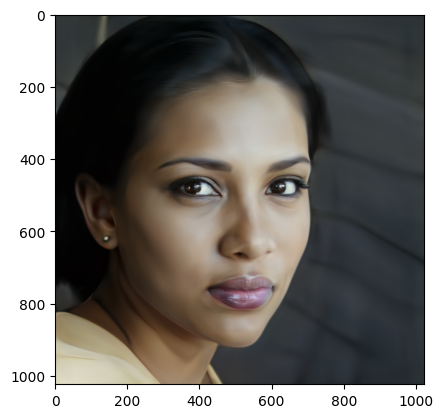

In [30]:
plt.imshow(images[0])

Problem 1b: Latent space traversals

In [ ]:
# Your code goes here.

# Problem 2: CLIP

In [ ]:
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
import clip

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

cifar = np.load('/content/drive/MyDrive/ELEC 477/CIFAR.npz') # Replace with your path to CIFAR.
X,y,label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
print(label_names)

In [ ]:
from tqdm import tqdm
captions = None # Your code goes here.

# Iterate over all test examples.
for i in tqdm(range(50000, 60000)): 
  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')
  text = clip.tokenize(captions).to(device)

  with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Your code goes here.

# Your code goes here.